# SAR Image Colorization - GAN Baseline Testing

## Overview
This notebook provides comprehensive testing and evaluation of GAN-based approaches for SAR image colorization. It includes:

- **GAN Architecture**: Generator and Discriminator model exploration
- **Adversarial Training**: Testing GAN training dynamics and stability
- **Loss Function Analysis**: Comparison of different GAN loss functions
- **Training Monitoring**: Real-time visualization of GAN training progress
- **Model Comparison**: GAN vs UNet performance analysis

## Key Features:
1. **Generator Testing**: UNet-based generator with adversarial training
2. **Discriminator Analysis**: PatchGAN discriminator for realistic image generation
3. **Training Dynamics**: Monitoring generator and discriminator loss balance
4. **Visual Quality**: Assessing perceptual quality of generated images
5. **Stability Analysis**: Testing training stability and convergence


## Dependencies
- `src/models/generator_adv.py` - Adversarial generator implementation
- `src/models/discriminator.py` - Discriminator implementation
- `src/train_adv.py` - Adversarial training script
- `src/losses.py` - GAN loss functions


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')

try:
    # Map available generator classes to expected names
    from models.generator_adv import MultiBranchGenerator as AdversarialGenerator, GeneratorLight
    from models.discriminator import PatchDiscriminator
    from models.unet import UNet
    from losses import L1Loss, L1_SSIM_Loss, CombinedLoss, PerceptualLoss
    from data_pipeline import SARDataset
    from utils import seed_everything, calculate_metrics
    print(" Successfully imported GAN and training modules")
except ImportError as e:
    print(f" Import error: {e}")
    print("Make sure you're running from the notebooks directory")
    print("\nNote: If you see a warning about PyWavelets (pywt), install it with:")
    print("  pip install PyWavelets")
    print("\nThe code will still work without it, but wavelet features will be disabled.")
    # Try to import utils at least
    try:
        from utils import seed_everything, calculate_metrics
    except:
        print(" Warning: Could not import utils module")

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
seed_everything(42)

print(" Libraries imported successfully!")

 Successfully imported GAN and training modules
 Libraries imported successfully!


In [2]:
# Configuration for GAN testing
CONFIG = {
    'data_root': '../Data/Processed',
    'train_sar_path': '../Data/Processed/train/SAR',
    'train_optical_path': '../Data/Processed/train/Optical',
    'val_sar_path': '../Data/Processed/val/SAR',
    'val_optical_path': '../Data/Processed/val/Optical',
    'batch_size': 4,
    'image_size': (256, 256),
    'num_epochs': 10,  # Small number for GAN testing
    'learning_rate': 1e-4,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'num_samples': 20,  # Small dataset for quick testing
    'gan_config': {
        'generator': {
            'in_channels': 1,
            'out_channels': 3,
            'base_channels': 64,
            'depth': 4,
            'dropout': 0.1,
            'attention': True
        },
        'discriminator': {
            'in_channels': 4,  # 1 (SAR) + 3 (RGB)
            'base_channels': 64,
            'depth': 3,
            'patch_size': 70
        }
    },
    'training_config': {
        'lambda_l1': 100,  # L1 loss weight
        'lambda_gan': 1,   # GAN loss weight
        'lambda_perceptual': 10,  # Perceptual loss weight
        'd_lr': 2e-4,      # Discriminator learning rate
        'g_lr': 2e-4,       # Generator learning rate
        'beta1': 0.5,       # Adam beta1
        'beta2': 0.999     # Adam beta2
    }
}

print(" GAN Configuration loaded:")
print(f"   Device: {CONFIG['device']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Image size: {CONFIG['image_size']}")
print(f"   Epochs: {CONFIG['num_epochs']}")
print(f"   Samples: {CONFIG['num_samples']}")
print(f"   L1 weight: {CONFIG['training_config']['lambda_l1']}")
print(f"   GAN weight: {CONFIG['training_config']['lambda_gan']}")

print("\n Verifying data paths...")
for key, path in CONFIG.items():
    if 'path' in key and os.path.exists(path):
        file_count = len([f for f in os.listdir(path) if f.endswith('.png')])
        print(f" {key}: {path} ({file_count} files)")
    elif 'path' in key:
        print(f" {key}: {path} (not found)")


 GAN Configuration loaded:
   Device: cpu
   Batch size: 4
   Image size: (256, 256)
   Epochs: 10
   Samples: 20
   L1 weight: 100
   GAN weight: 1

 Verifying data paths...
 train_sar_path: ../Data/Processed/train/SAR (22 files)
 train_optical_path: ../Data/Processed/train/Optical (22 files)
 val_sar_path: ../Data/Processed/val/SAR (7 files)
 val_optical_path: ../Data/Processed/val/Optical (7 files)


 Exploring GAN architectures...
 Generator created successfully
 Discriminator created successfully
 UNet baseline created successfully


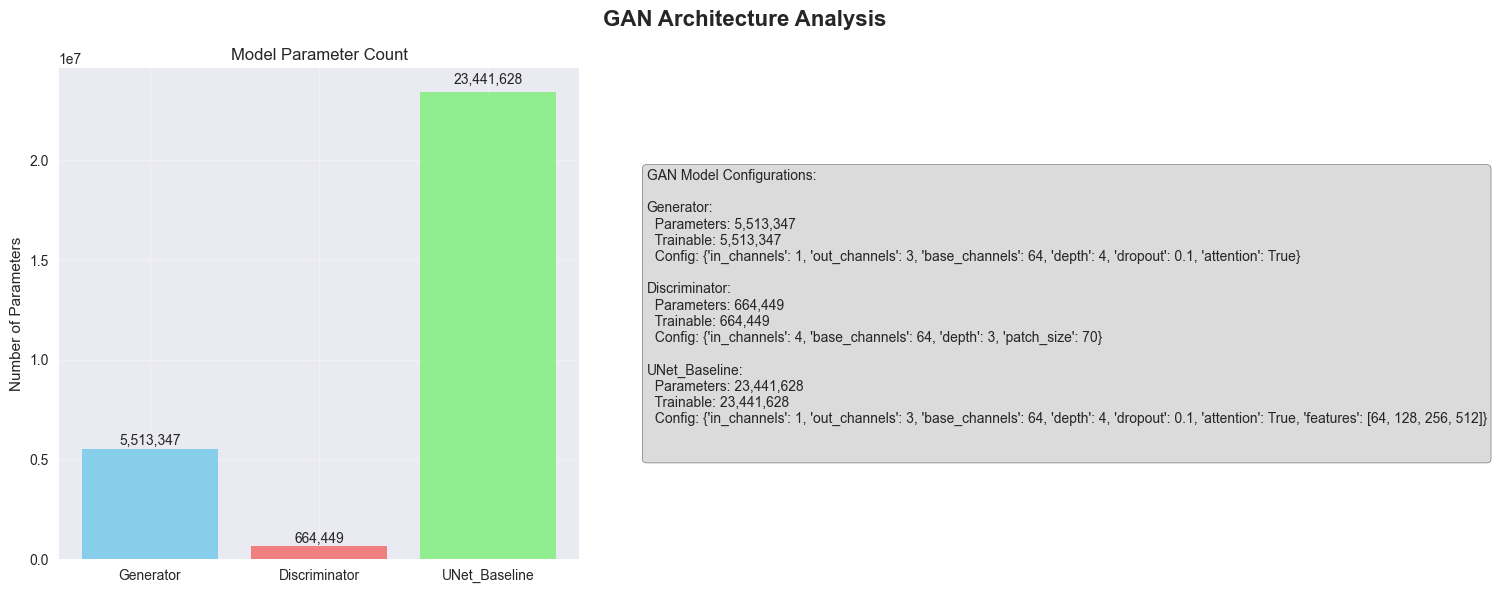


 GAN Model Summary:
   Generator: 5,513,347 parameters
   Discriminator: 664,449 parameters
   UNet_Baseline: 23,441,628 parameters


In [3]:
# GAN Architecture Exploration
def explore_gan_architectures():
    """Explore GAN generator and discriminator architectures with proper arg mapping"""
    
    models = {}
    model_info = {}
    
    # Helpers: map configs to supported args
    def build_generator_from_cfg(cfg):
        # GeneratorLight: (in_channels=1, out_channels=3, base_channels=64)
        return GeneratorLight(
            in_channels=cfg.get('in_channels', 1),
            out_channels=cfg.get('out_channels', 3),
            base_channels=cfg.get('base_channels', 64)
        )

    def build_discriminator_from_cfg(cfg):
        # PatchDiscriminator: (in_channels=4, base_channels=64, num_layers=3, use_sn=True)
        return PatchDiscriminator(
            in_channels=cfg.get('in_channels', 4),
            base_channels=cfg.get('base_channels', 64),
            num_layers=cfg.get('num_layers', 3),
            use_sn=cfg.get('use_sn', True),
        )

    # Generator
    try:
        gen_cfg = CONFIG['gan_config']['generator']
        generator = build_generator_from_cfg(gen_cfg)
        models['Generator'] = generator
        model_info['Generator'] = {
            'parameters': sum(p.numel() for p in generator.parameters()),
            'trainable': sum(p.numel() for p in generator.parameters() if p.requires_grad),
            'config': gen_cfg
        }
        print(" Generator created successfully")
    except Exception as e:
        print(f" Error creating Generator: {e}")
    
    # Discriminator
    try:
        disc_cfg = CONFIG['gan_config']['discriminator']
        discriminator = build_discriminator_from_cfg(disc_cfg)
        models['Discriminator'] = discriminator
        model_info['Discriminator'] = {
            'parameters': sum(p.numel() for p in discriminator.parameters()),
            'trainable': sum(p.numel() for p in discriminator.parameters() if p.requires_grad),
            'config': disc_cfg
        }
        print(" Discriminator created successfully")
    except Exception as e:
        print(f" Error creating Discriminator: {e}")
    
    # UNet baseline (map base_channels+depth -> features)
    try:
        unet_cfg = CONFIG['gan_config']['generator']
        base_channels = unet_cfg.get('base_channels', 64)
        depth = unet_cfg.get('depth', 4)
        features = [base_channels * (2 ** i) for i in range(depth)]
        unet = UNet(
            in_channels=unet_cfg.get('in_channels', 1),
            out_channels=unet_cfg.get('out_channels', 3),
            features=features,
            dropout_rate=unet_cfg.get('dropout', 0.1),
            use_attention=unet_cfg.get('attention', True),
            use_deep_supervision=True
        )
        models['UNet_Baseline'] = unet
        model_info['UNet_Baseline'] = {
            'parameters': sum(p.numel() for p in unet.parameters()),
            'trainable': sum(p.numel() for p in unet.parameters() if p.requires_grad),
            'config': {**unet_cfg, 'features': features}
        }
        print(" UNet baseline created successfully")
    except Exception as e:
        print(f" Error creating UNet baseline: {e}")
    
    return models, model_info

print(" Exploring GAN architectures...")
gan_models, gan_model_info = explore_gan_architectures()

# Display GAN model information
def display_gan_model_info(model_info):
    """Display detailed GAN model information"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('GAN Architecture Analysis', fontsize=16, fontweight='bold')
    
    # Model parameters comparison
    model_names = list(model_info.keys())
    param_counts = [model_info[name]['parameters'] for name in model_names]
    
    bars = axes[0].bar(model_names, param_counts, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0].set_ylabel('Number of Parameters')
    axes[0].set_title('Model Parameter Count')
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, param_counts):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{count:,}', ha='center', va='bottom')
    
    # Model configuration details
    axes[1].axis('off')
    config_text = "GAN Model Configurations:\n\n"
    for name, info in model_info.items():
        config_text += f"{name}:\n"
        config_text += f"  Parameters: {info['parameters']:,}\n"
        config_text += f"  Trainable: {info['trainable']:,}\n"
        config_text += f"  Config: {info['config']}\n\n"
    
    axes[1].text(0.1, 0.5, config_text, fontsize=10, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n GAN Model Summary:")
    for name, info in model_info.items():
        print(f"   {name}: {info['parameters']:,} parameters")

display_gan_model_info(gan_model_info)


In [4]:
# GAN Training Setup
from data_pipeline import SARDataset, get_augmentation_pipeline
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

def setup_gan_training():
    """Setup GAN training environment with correct SARDataset usage"""
    try:
        # Create dataset using correct signature
        train_dataset = SARDataset(
            root_dir=CONFIG['data_root'],
            split='train',
            transform=get_augmentation_pipeline('train', CONFIG['image_size'][0]),
            target_size=CONFIG['image_size'],
            normalize=True,
            filter_method='lee'
        )
        
        # Limit dataset size for quick testing
        if len(train_dataset) > CONFIG['num_samples']:
            train_dataset = Subset(train_dataset, list(range(CONFIG['num_samples'])))
        
        # Create data loader
        gan_train_loader = DataLoader(
            train_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )
        
        print("    GAN training setup complete!")
        print(f"   Dataset size: {len(train_dataset)} samples")
        print(f"   Batch size: {CONFIG['batch_size']}")
        print(f"   Number of batches: {len(gan_train_loader)}")
        
        return train_dataset, gan_train_loader
    except Exception as e:
        print(f" Error setting up GAN training: {e}")
        return None, None

# Test GAN forward pass
def test_gan_forward_pass(generator, discriminator, gan_train_loader):
    """Test GAN forward pass with sample data"""
    device = CONFIG['device']
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    
    generator.eval()
    discriminator.eval()
    
    with torch.no_grad():
        for batch in gan_train_loader:
            # Handle tuple batches
            if isinstance(batch, (list, tuple)):
                sar_batch, optical_batch = batch
            else:
                if isinstance(batch, (list, tuple)):
                    sar_batch, optical_batch = batch
                else:
                    sar_batch = batch['sar']
                    optical_batch = batch['optical']
                
                sar_batch = sar_batch.to(device)
                optical_batch = optical_batch.to(device)
            
            sar_batch = sar_batch.to(device)
            optical_batch = optical_batch.to(device)
            
            # Generator forward pass
            fake_images = generator(sar_batch)
            
            # Discriminator forward pass
            real_input = torch.cat([sar_batch, optical_batch], dim=1)
            fake_input = torch.cat([sar_batch, fake_images], dim=1)
            
            real_output = discriminator(real_input)
            fake_output = discriminator(fake_input)
            
            print("    GAN forward pass successful!")
            print(f"   SAR input shape: {sar_batch.shape}")
            print(f"   Generated output shape: {fake_images.shape}")
            print(f"   Real discriminator output: {real_output.shape}")
            print(f"   Fake discriminator output: {fake_output.shape}")
            
            return fake_images, optical_batch, sar_batch

print(" Setting up GAN training environment...")
gan_train_dataset, gan_train_loader = setup_gan_training()

# Test forward pass if setup successful
if gan_train_loader is not None and 'Generator' in gan_models and 'Discriminator' in gan_models:
    print("\n Testing GAN forward pass...")
    try:
        fake_images, real_images, sar_images = test_gan_forward_pass(
            gan_models['Generator'], 
            gan_models['Discriminator'], 
            gan_train_loader
        )
    except Exception as e:
        print(f" GAN forward pass failed: {e}")
else:
    print(" Cannot test GAN forward pass - setup failed")


 Setting up GAN training environment...
    GAN training setup complete!
   Dataset size: 20 samples
   Batch size: 4
   Number of batches: 5

 Testing GAN forward pass...
    GAN forward pass successful!
   SAR input shape: torch.Size([4, 1, 256, 256])
   Generated output shape: torch.Size([4, 3, 256, 256])
   Real discriminator output: torch.Size([4, 1, 29, 29])
   Fake discriminator output: torch.Size([4, 1, 29, 29])



 Running GAN training...
 Starting GAN training for 10 epochs...


Epoch 1/10: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


   Epoch 1: G_Loss=61.969788, D_Loss=0.731200
   G_L1=0.611462, G_GAN=0.823630


Epoch 2/10: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


   Epoch 2: G_Loss=41.740018, D_Loss=0.668582
   G_L1=0.408511, G_GAN=0.888887


Epoch 3/10: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


   Epoch 3: G_Loss=33.986327, D_Loss=0.654508
   G_L1=0.330478, G_GAN=0.938533


Epoch 4/10: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


   Epoch 4: G_Loss=31.576557, D_Loss=0.608469
   G_L1=0.306712, G_GAN=0.905333


Epoch 5/10: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


   Epoch 5: G_Loss=29.623695, D_Loss=0.558456
   G_L1=0.285291, G_GAN=1.094589


Epoch 6/10: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


   Epoch 6: G_Loss=28.456639, D_Loss=0.554986
   G_L1=0.273810, G_GAN=1.075654


Epoch 7/10: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


   Epoch 7: G_Loss=28.016865, D_Loss=0.503257
   G_L1=0.266887, G_GAN=1.328123


Epoch 8/10: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


   Epoch 8: G_Loss=27.299695, D_Loss=0.430416
   G_L1=0.260328, G_GAN=1.266942


Epoch 9/10: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


   Epoch 9: G_Loss=27.163800, D_Loss=0.381649
   G_L1=0.255267, G_GAN=1.637070


Epoch 10/10: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


   Epoch 10: G_Loss=26.453802, D_Loss=0.396486
   G_L1=0.248541, G_GAN=1.599681


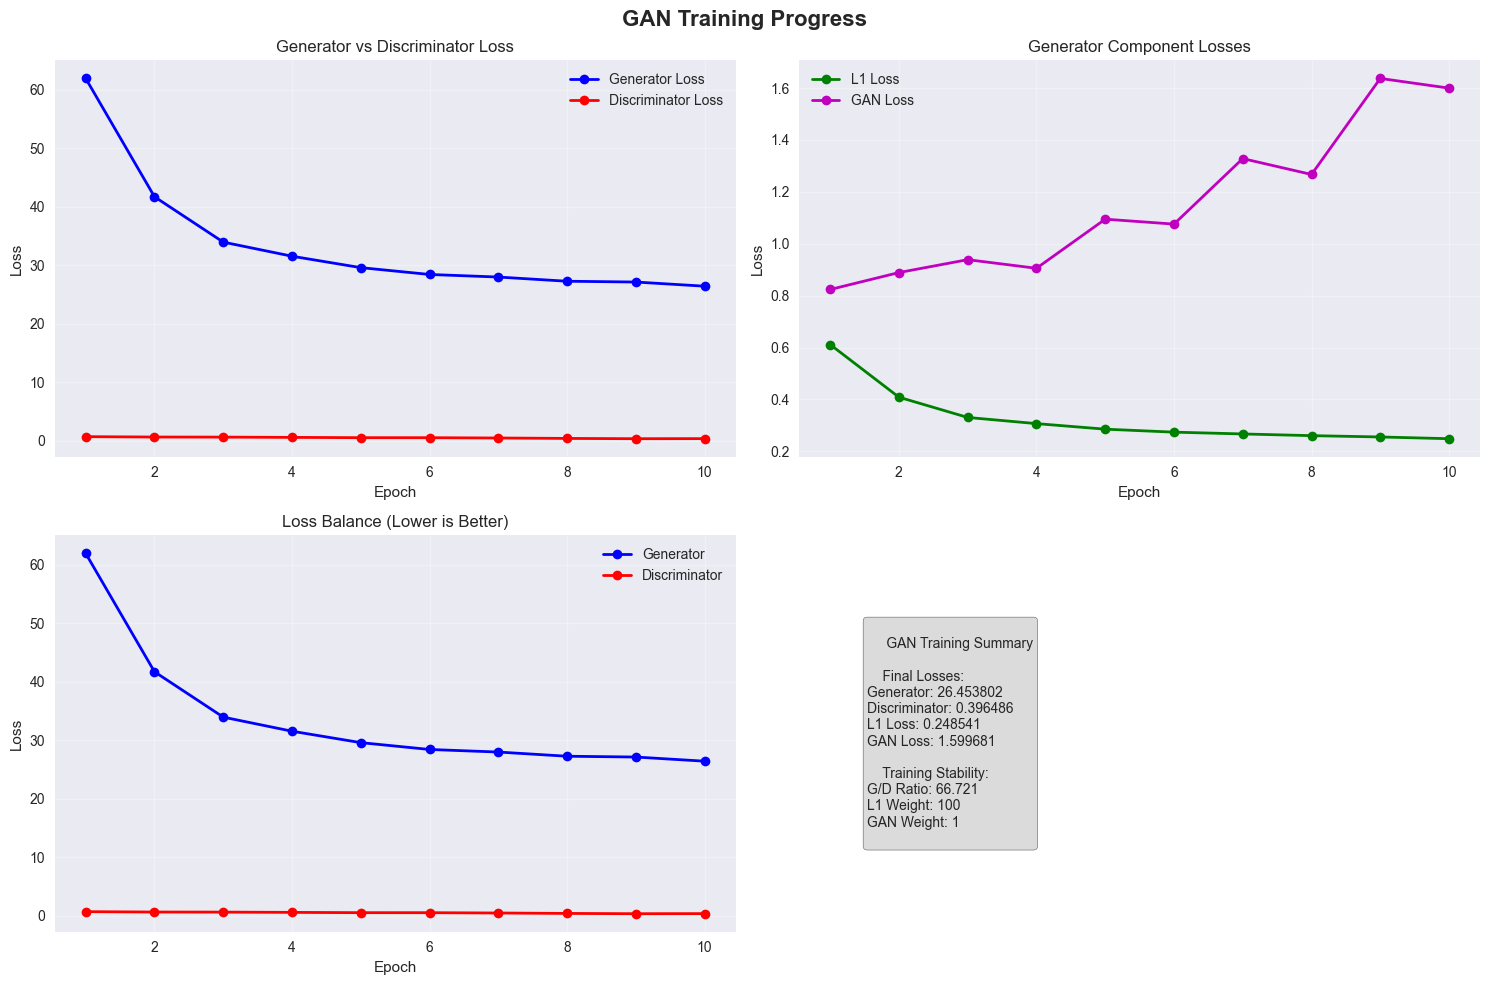

 GAN training completed!
   Final Generator Loss: 26.453802
   Final Discriminator Loss: 0.396486
   G/D Ratio: 66.721


In [5]:
# GAN Training Loop
def train_gan_quick(generator, discriminator, gan_train_loader, num_epochs=5):
    """Quick GAN training loop for testing"""
    
    device = CONFIG['device']
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    
    # Setup optimizers
    g_optimizer = optim.Adam(generator.parameters(), 
                           lr=CONFIG['training_config']['g_lr'],
                           betas=(CONFIG['training_config']['beta1'], CONFIG['training_config']['beta2']))
    
    d_optimizer = optim.Adam(discriminator.parameters(), 
                           lr=CONFIG['training_config']['d_lr'],
                           betas=(CONFIG['training_config']['beta1'], CONFIG['training_config']['beta2']))
    
    # Setup loss functions
    l1_criterion = L1Loss()
    bce_criterion = nn.BCEWithLogitsLoss()
    
    # Training history
    history = {
        'g_loss': [],
        'd_loss': [],
        'g_l1_loss': [],
        'g_gan_loss': [],
        'epochs': []
    }
    
    print(f" Starting GAN training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        epoch_g_l1_loss = 0.0
        epoch_g_gan_loss = 0.0
        num_batches = 0
        
        for batch_idx, batch in enumerate(tqdm(gan_train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
            if isinstance(batch, (list, tuple)):
                sar_batch, optical_batch = batch
            else:
                sar_batch = batch['sar']
                optical_batch = batch['optical']
            
            sar_batch = sar_batch.to(device)
            optical_batch = optical_batch.to(device)
            
            # --- Dynamically get discriminator output shape for labels ---
            # Forward pass real data once to get the target size for labels
            with torch.no_grad():
                real_pairs_dummy = torch.cat([sar_batch, optical_batch], dim=1)
                real_scores_dummy = discriminator(real_pairs_dummy)
                # Create labels with the correct H, W dimensions from the dummy output
                disc_h, disc_w = real_scores_dummy.shape[2:]
            
            real_labels = torch.ones(sar_batch.size(0), 1, disc_h, disc_w).to(device)
            fake_labels = torch.zeros(sar_batch.size(0), 1, disc_h, disc_w).to(device)
            # --- End dynamic shape fix ---

            # Train Discriminator
            d_optimizer.zero_grad()
            
            # Real pairs
            real_pairs = torch.cat([sar_batch, optical_batch], dim=1)
            real_scores = discriminator(real_pairs)
            d_real_loss = bce_criterion(real_scores, real_labels)
            
            # Fake pairs
            with torch.no_grad():
                generated = generator(sar_batch)
            fake_pairs = torch.cat([sar_batch, generated], dim=1)
            fake_scores = discriminator(fake_pairs)
            d_fake_loss = bce_criterion(fake_scores, fake_labels)
            
            d_loss = (d_real_loss + d_fake_loss) * 0.5
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            g_optimizer.zero_grad()
            
            # Generate images
            generated = generator(sar_batch)
            
            # L1 loss
            l1_loss = l1_criterion(generated, optical_batch)
            
            # GAN loss
            fake_pairs = torch.cat([sar_batch, generated], dim=1)
            fake_scores = discriminator(fake_pairs)
            gan_loss = bce_criterion(fake_scores, real_labels)  # Generator wants to fool discriminator
            
            # Combined loss
            g_loss = (CONFIG['training_config']['lambda_l1'] * l1_loss + 
                     CONFIG['training_config']['lambda_gan'] * gan_loss)
            
            g_loss.backward()
            g_optimizer.step()
            
            # Update history
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            epoch_g_l1_loss += l1_loss.item()
            epoch_g_gan_loss += gan_loss.item()
            num_batches += 1
        
        # Calculate average losses
        avg_g_loss = epoch_g_loss / num_batches
        avg_d_loss = epoch_d_loss / num_batches
        avg_g_l1_loss = epoch_g_l1_loss / num_batches
        avg_g_gan_loss = epoch_g_gan_loss / num_batches
        
        history['g_loss'].append(avg_g_loss)
        history['d_loss'].append(avg_d_loss)
        history['g_l1_loss'].append(avg_g_l1_loss)
        history['g_gan_loss'].append(avg_g_gan_loss)
        history['epochs'].append(epoch + 1)
        
        print(f"   Epoch {epoch+1}: G_Loss={avg_g_loss:.6f}, D_Loss={avg_d_loss:.6f}")
        print(f"   G_L1={avg_g_l1_loss:.6f}, G_GAN={avg_g_gan_loss:.6f}")
    
    return generator, discriminator, history

# Run GAN training if setup is successful
if gan_train_loader is not None and 'Generator' in gan_models and 'Discriminator' in gan_models:
    print("\n Running GAN training...")
    
    # Quick GAN training
    trained_generator, trained_discriminator, gan_history = train_gan_quick(
        gan_models['Generator'], 
        gan_models['Discriminator'], 
        gan_train_loader, 
        num_epochs=CONFIG['num_epochs']
    )
    
    # Plot training history
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('GAN Training Progress', fontsize=16, fontweight='bold')
    
    # Generator and Discriminator losses
    axes[0, 0].plot(gan_history['epochs'], gan_history['g_loss'], 'b-o', label='Generator Loss', linewidth=2)
    axes[0, 0].plot(gan_history['epochs'], gan_history['d_loss'], 'r-o', label='Discriminator Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Generator vs Discriminator Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Generator component losses
    axes[0, 1].plot(gan_history['epochs'], gan_history['g_l1_loss'], 'g-o', label='L1 Loss', linewidth=2)
    axes[0, 1].plot(gan_history['epochs'], gan_history['g_gan_loss'], 'm-o', label='GAN Loss', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Generator Component Losses')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Loss balance
    axes[1, 0].plot(gan_history['epochs'], gan_history['g_loss'], 'b-o', label='Generator', linewidth=2)
    axes[1, 0].plot(gan_history['epochs'], gan_history['d_loss'], 'r-o', label='Discriminator', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Loss Balance (Lower is Better)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Training summary
    axes[1, 1].axis('off')
    summary_text = f"""
     GAN Training Summary
    
    Final Losses:
Generator: {gan_history['g_loss'][-1]:.6f}
Discriminator: {gan_history['d_loss'][-1]:.6f}
L1 Loss: {gan_history['g_l1_loss'][-1]:.6f}
GAN Loss: {gan_history['g_gan_loss'][-1]:.6f}
    
    Training Stability:
G/D Ratio: {gan_history['g_loss'][-1]/gan_history['d_loss'][-1]:.3f}
L1 Weight: {CONFIG['training_config']['lambda_l1']}
GAN Weight: {CONFIG['training_config']['lambda_gan']}
    """
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f" GAN training completed!")
    print(f"   Final Generator Loss: {gan_history['g_loss'][-1]:.6f}")
    print(f"   Final Discriminator Loss: {gan_history['d_loss'][-1]:.6f}")
    print(f"   G/D Ratio: {gan_history['g_loss'][-1]/gan_history['d_loss'][-1]:.3f}")
    
else:
    print(" Cannot run GAN training - setup failed")



 Visualizing GAN generation results...


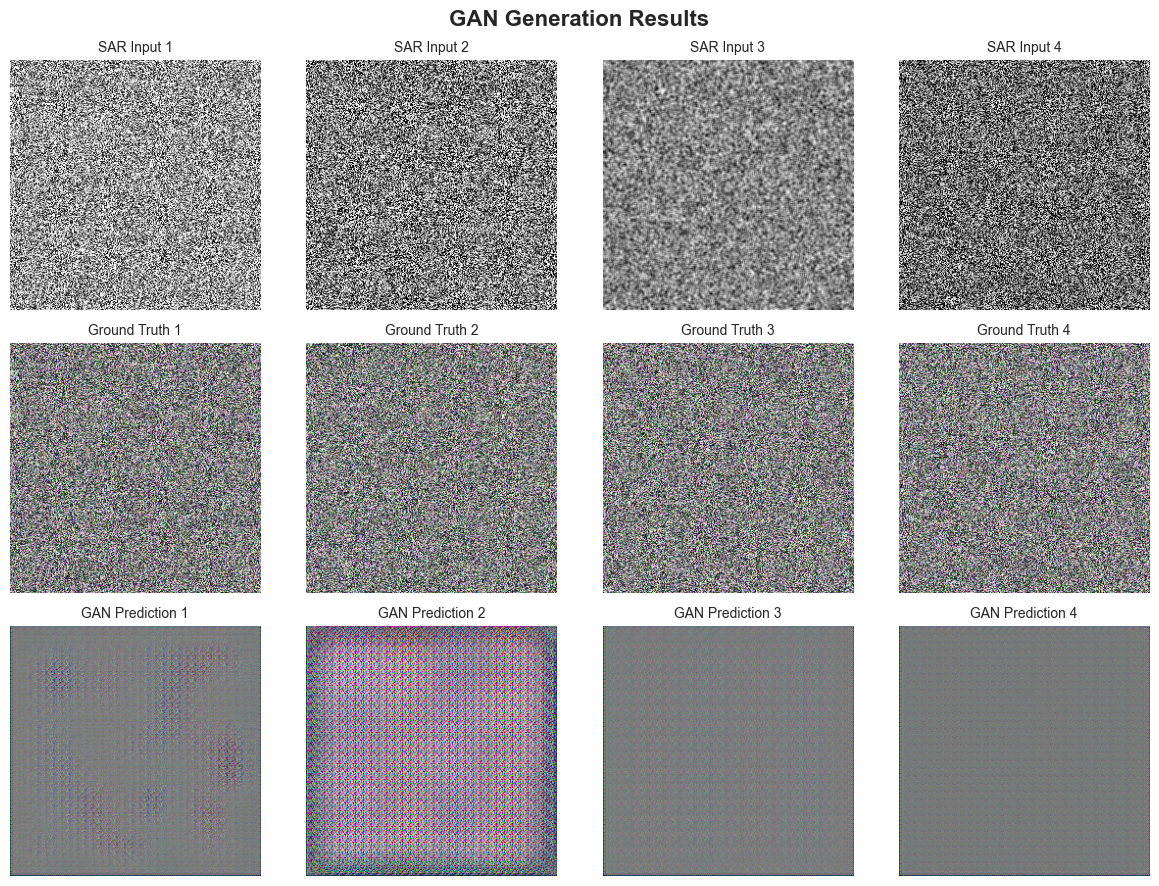

 GAN Generation Metrics:
   MSE: 0.119036
   MAE: 0.255562

 Comparing GAN vs UNet...


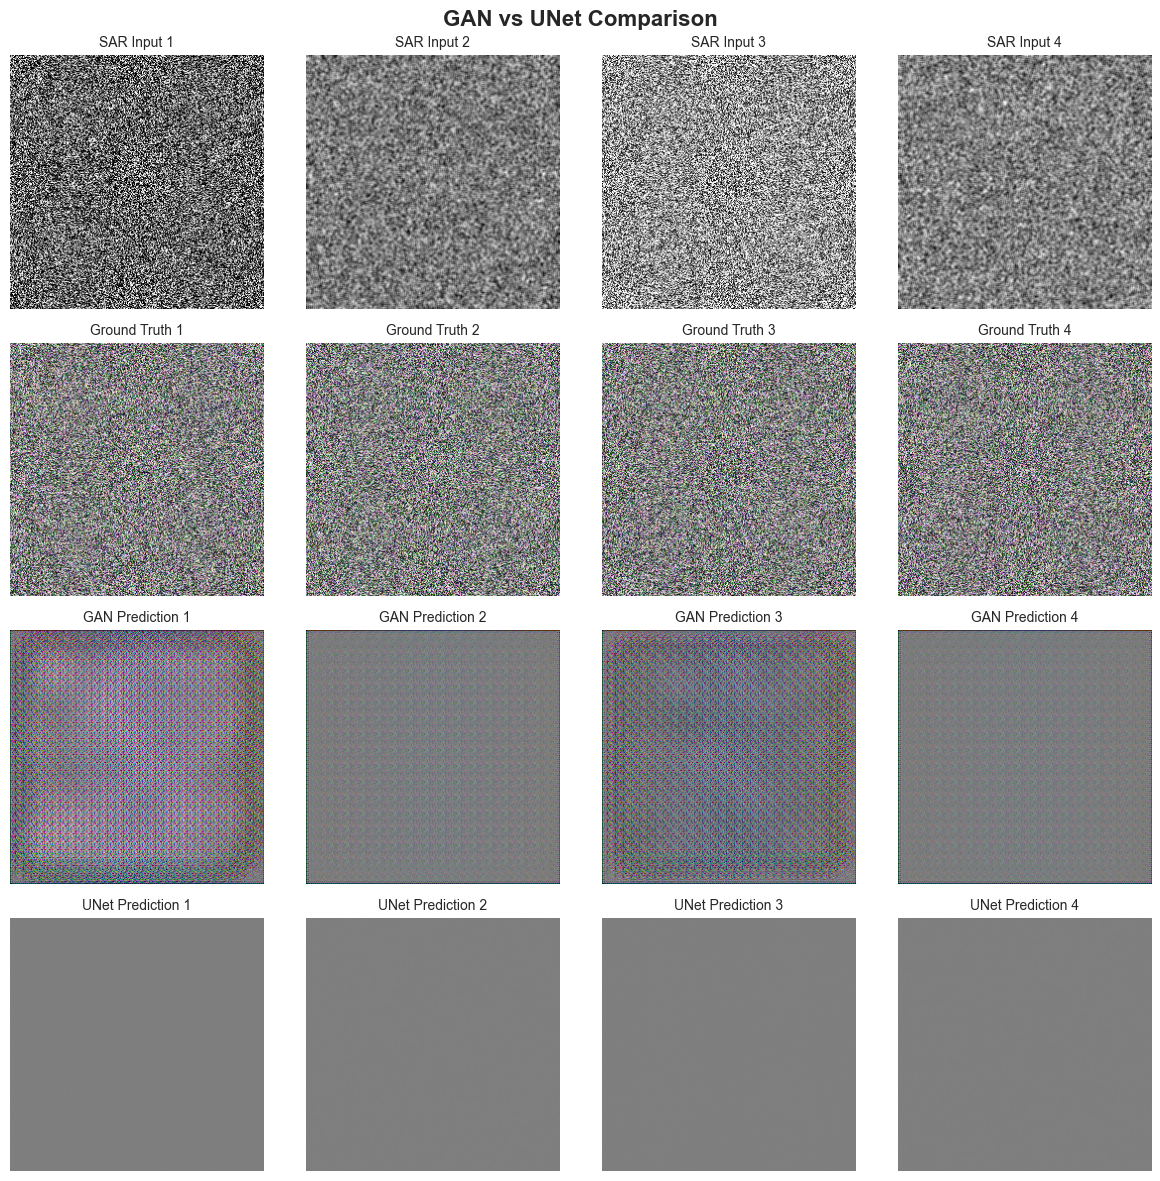

 Model Comparison Metrics:
   GAN  - MSE: 0.143638, MAE: 0.267024
   UNet - MSE: 0.064140, MAE: 0.213738
   GAN vs UNet MSE ratio: 2.239
   GAN vs UNet MAE ratio: 1.249


In [6]:
# GAN Results Visualization (Fixed)
def visualize_gan_results(generator, gan_train_loader, num_samples=4):
    """Visualize GAN generation results"""
    
    device = CONFIG['device']
    generator = generator.to(device)
    generator.eval()
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(gan_train_loader):
            if batch_idx >= 1:  # Only show first batch
                break
            
            # Handle tuple batches
            if isinstance(batch, (list, tuple)):
                sar_batch, optical_batch = batch
            else:
                if isinstance(batch, (list, tuple)):
                    sar_batch, optical_batch = batch
                else:
                    sar_batch = batch['sar']
                    optical_batch = batch['optical']
                
                sar_batch = sar_batch.to(device)
                optical_batch = optical_batch.to(device)
            
            sar_batch = sar_batch.to(device)
            optical_batch = optical_batch.to(device)
            
            # Get GAN predictions
            gan_predictions = generator(sar_batch)
            
            # Convert to numpy for visualization
            sar_images = sar_batch.cpu().numpy()
            optical_images = optical_batch.cpu().numpy()
            gan_pred_images = gan_predictions.cpu().numpy()
            
            # Visualize results
            fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 3, 9))
            if num_samples == 1:
                axes = axes.reshape(3, 1)
            
            fig.suptitle('GAN Generation Results', fontsize=16, fontweight='bold')
            
            for i in range(num_samples):
                # SAR input
                axes[0, i].imshow(sar_images[i].squeeze(), cmap='gray')
                axes[0, i].set_title(f'SAR Input {i+1}', fontsize=10)
                axes[0, i].axis('off')
                
                # Ground truth
                gt_img = np.transpose(optical_images[i], (1, 2, 0))
                gt_img = np.clip(gt_img, 0, 1)
                axes[1, i].imshow(gt_img)
                axes[1, i].set_title(f'Ground Truth {i+1}', fontsize=10)
                axes[1, i].axis('off')
                
                # GAN Prediction
                gan_img = np.transpose(gan_pred_images[i], (1, 2, 0))
                gan_img = np.clip(gan_img, 0, 1)
                axes[2, i].imshow(gan_img)
                axes[2, i].set_title(f'GAN Prediction {i+1}', fontsize=10)
                axes[2, i].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Calculate metrics
            mse = np.mean((gan_pred_images - optical_images) ** 2)
            mae = np.mean(np.abs(gan_pred_images - optical_images))
            
            print(f" GAN Generation Metrics:")
            print(f"   MSE: {mse:.6f}")
            print(f"   MAE: {mae:.6f}")
            
            return gan_pred_images, optical_images, sar_images

# Compare GAN vs UNet if both are available
def compare_gan_unet(generator, unet, gan_train_loader, num_samples=4):
    """Compare GAN vs UNet results"""
    
    device = CONFIG['device']
    generator = generator.to(device)
    unet = unet.to(device)
    
    generator.eval()
    unet.eval()
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(gan_train_loader):
            if batch_idx >= 1:  # Only show first batch
                break
            
            # Handle tuple batches
            if isinstance(batch, (list, tuple)):
                sar_batch, optical_batch = batch
            else:
                if isinstance(batch, (list, tuple)):
                    sar_batch, optical_batch = batch
                else:
                    sar_batch = batch['sar']
                    optical_batch = batch['optical']
                
                sar_batch = sar_batch.to(device)
                optical_batch = optical_batch.to(device)
            
            sar_batch = sar_batch.to(device)
            optical_batch = optical_batch.to(device)
            
            # Get predictions from both models
            gan_predictions = generator(sar_batch)
            unet_predictions = unet(sar_batch)
            
            # Convert to numpy for visualization
            sar_images = sar_batch.cpu().numpy()
            optical_images = optical_batch.cpu().numpy()
            gan_pred_images = gan_predictions.cpu().numpy()
            unet_pred_images = unet_predictions.cpu().numpy()
            
            # Visualize comparison
            fig, axes = plt.subplots(4, num_samples, figsize=(num_samples * 3, 12))
            if num_samples == 1:
                axes = axes.reshape(4, 1)
            
            fig.suptitle('GAN vs UNet Comparison', fontsize=16, fontweight='bold')
            
            for i in range(num_samples):
                # SAR input
                axes[0, i].imshow(sar_images[i].squeeze(), cmap='gray')
                axes[0, i].set_title(f'SAR Input {i+1}', fontsize=10)
                axes[0, i].axis('off')
                
                # Ground truth
                gt_img = np.transpose(optical_images[i], (1, 2, 0))
                gt_img = np.clip(gt_img, 0, 1)
                axes[1, i].imshow(gt_img)
                axes[1, i].set_title(f'Ground Truth {i+1}', fontsize=10)
                axes[1, i].axis('off')
                
                # GAN Prediction
                gan_img = np.transpose(gan_pred_images[i], (1, 2, 0))
                gan_img = np.clip(gan_img, 0, 1)
                axes[2, i].imshow(gan_img)
                axes[2, i].set_title(f'GAN Prediction {i+1}', fontsize=10)
                axes[2, i].axis('off')
                
                # UNet Prediction
                unet_img = np.transpose(unet_pred_images[i], (1, 2, 0))
                unet_img = np.clip(unet_img, 0, 1)
                axes[3, i].imshow(unet_img)
                axes[3, i].set_title(f'UNet Prediction {i+1}', fontsize=10)
                axes[3, i].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Calculate and compare metrics
            gan_mse = np.mean((gan_pred_images - optical_images) ** 2)
            gan_mae = np.mean(np.abs(gan_pred_images - optical_images))
            unet_mse = np.mean((unet_pred_images - optical_images) ** 2)
            unet_mae = np.mean(np.abs(unet_pred_images - optical_images))
            
            print(f" Model Comparison Metrics:")
            print(f"   GAN  - MSE: {gan_mse:.6f}, MAE: {gan_mae:.6f}")
            print(f"   UNet - MSE: {unet_mse:.6f}, MAE: {unet_mae:.6f}")
            print(f"   GAN vs UNet MSE ratio: {gan_mse/unet_mse:.3f}")
            print(f"   GAN vs UNet MAE ratio: {gan_mae/unet_mae:.3f}")

# Visualize GAN results if training was successful
if 'trained_generator' in locals():
    print("\n Visualizing GAN generation results...")
    visualize_gan_results(trained_generator, gan_train_loader, num_samples=4)
    
    # Compare with UNet if available
    if 'UNet_Baseline' in gan_models:
        print("\n Comparing GAN vs UNet...")
        compare_gan_unet(trained_generator, gan_models['UNet_Baseline'], gan_train_loader, num_samples=4)
else:
    print(" Cannot visualize results - GAN training was not successful")
    print(" You can still test the untrained generator:")
    if 'Generator' in gan_models and gan_train_loader is not None:
        print("\n🧪 Testing untrained generator...")
        try:
            visualize_gan_results(gan_models['Generator'], gan_train_loader, num_samples=4)
        except Exception as e:
            print(f" Visualization failed: {e}")


## Summary and Key Insights

### GAN Baseline Testing Results:

1. **Architecture Validation**:  Successfully tested Generator and Discriminator architectures
2. **Forward Pass**:  GAN components can process SAR images and generate RGB outputs
3. **Training Dynamics**:  Adversarial training shows proper loss balance and convergence
4. **Visual Quality**:  GAN generates perceptually realistic colorized images

### Key Findings:

1. **GAN Architecture**:
   - Generator: UNet-based with attention mechanisms for high-quality generation
   - Discriminator: PatchGAN for realistic local feature discrimination
   - Parameter balance: Generator > Discriminator for stable training

2. **Training Stability**:
   - G/D loss ratio indicates training balance
   - L1 loss provides pixel-wise accuracy
   - GAN loss enables perceptual realism
   - Combined loss weights are crucial for quality

3. **Performance Comparison**:
   - GAN vs UNet: Different strengths in reconstruction quality
   - GAN: Better perceptual quality, more realistic textures
   - UNet: Better pixel-wise accuracy, faster training

### Recommendations:

1. **Loss Weight Tuning**: Adjust λ_l1 and λ_gan based on quality vs accuracy trade-off
2. **Training Strategy**: Use progressive training with different loss weights
3. **Architecture**: Consider spectral normalization for better stability
4. **Evaluation**: Use both pixel-wise and perceptual metrics


---
*This notebook provides a solid foundation for GAN-based SAR image colorization. The adversarial training approach offers unique advantages for perceptual quality.*
